#### Math from fipy example description:

Spinodal decomposition can be described by the "Cahn-Hilliard"
equation (also known as "conserved Ginsberg-Landau" or "model B" of Hohenberg & Halperin)

$\frac{\partial \phi}{\partial t}
   = \nabla\cdot D \nabla\left( \frac{\partial f}{\partial \phi}   - \epsilon^2 \nabla^2 \phi\right)$
   
where $\phi$ is a conserved order parameter, possibly representing
alloy composition or spin. The double-well free energy function $f = (a^2/2) \phi^2 (1 - \phi)^2$ penalizes states with intermediate values of $\phi$
between 0 and 1. The gradient energy term $\epsilon^2 \nabla^2\phi$,
on the other hand, penalizes sharp changes of $\phi$.
These two competing effects result in the segregation
of $\phi$ into domains of 0 and 1, separated by abrupt, but
smooth, transitions. The parameters $a$ and $\epsilon$ determine the relative
weighting of the two effects and $D$ is a rate constant.


For FiPy, we need to perform the partial derivative
$\partial f/\partial \phi$
manually and then put the equation in the canonical
form by decomposing the spatial derivatives
so that each FiPy Term is of a single, even order:

   $\frac{\partial \phi}{\partial t}
    = \nabla\cdot D a^2 \left[ 1 - 6 \phi \left(1 - \phi\right)\right] \nabla \phi- \nabla\cdot D \nabla \epsilon^2 \nabla^2 \phi$
    
FiPy would automatically interpolate
$D a^2 \left[ 1 - 6 \phi \left(1 - \phi\right)\right]$
onto the faces, where the diffusive flux is calculated, but we obtain
somewhat more accurate results by performing a linear interpolation from
phi at cell centers to PHI at face centers.

In [21]:
import pathlib
from fipy import CellVariable, Grid3D, Viewer, GaussianNoiseVariable, Grid2D, TransientTerm, DiffusionTerm, DefaultSolver
from fipy.tools import numerix
import numpy as np
import matplotlib.pyplot as plt

In [98]:
### Define paths
notebookPath = pathlib.Path.cwd()
exportPath = notebookPath.joinpath('fipy_morphs/2D')

### Colormap
cmap = plt.cm.YlGnBu_r.copy()

In [136]:
2/1.3

1.5384615384615383

In [137]:
### Define mesh
nx = ny = 130
nz = 50
dx = dy = (2/1.3)
dz = 2
mesh = Grid3D(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz)
# mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)

### Define volume fraction map
phi = CellVariable(mesh=mesh, name='phi')
phi.setValue(GaussianNoiseVariable(mesh=mesh, mean=0.5, variance=0.05))

### Set equation 
PHI = phi.arithmeticFaceValue
D = 1.
a = 1.
epsilon = 1.
eq = (TransientTerm()
      == DiffusionTerm(coeff=D * a**2 * (1 - 6 * PHI * (1 - PHI)))
      - DiffusionTerm(coeff=(D, epsilon**2)))

### Initialize viewer
viewer = Viewer(vars=(phi,), datamin=0., datamax=1.)
elapsed = 0
viewer.cmap = cmap

qt.qpa.window: <QNSWindow: 0x155711060; contentView=<QNSView: 0x155710c50; QCocoaWindow(0x600002078fd0, window=QWidgetWindow(0x6000033f5620, name="TVTK Scene 1Window"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.
/Users/andrew/conda_install/envs/nrss/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,
ERROR|2023-05-06 12:37:56,011|Exception occurred in traits notification handler for object: <mayavi.core.module_manager.ModuleManager object at 0x168b12860>, trait: source, old value: None, new value: <mayavi.filters.data_set_clipper.DataSetClipper object at 0x175a5d950>
Traceback (most recent call last):
  File "/Users/andrew/conda_install/envs/nrss/lib/python3.9/site-pack

In [ ]:
target = 500
time_0 = time.time()

while elapsed < target:
    if elapsed < 4:
        dt = 1
    elif elapsed < 10:
        dt = 2
    elif elapsed < 100:
        dt = 5
    elif elapsed < 500:
        dt = 10
    else: 
        dt=20
    elapsed += dt  
    eq.solve(phi, dt=dt, solver=DefaultSolver(precon=None))
    viewer.plot()
    # for elapsed_value in (100, 200, 300, 400, 500, 600):
    #     if elapsed==elapsed_value:
    #         print(f'{elapsed} time steps in {np.round((time.time() - time_0), 1)} seconds!')

print(f'{elapsed} time steps in {np.round((time.time() - time_0), 1)} seconds!')

<Figure size 640x480 with 0 Axes>

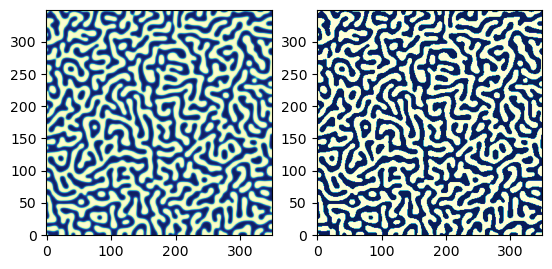

In [127]:
### Numpy:
data = phi.copy().value.reshape((nx, ny))
data_binary = data.copy()
data_binary[data<0.5] = 0
data_binary[data>=0.5] = 1

np.savetxt(exportPath.joinpath(f'{nx}x{ny}pix_{int(dx*nx)}x{int(dy*ny)}size_{int(elapsed)}steps_D{int(D)}_a{int(a)}_epsilon{int(epsilon)}.txt'), data)
np.savetxt(exportPath.joinpath(f'{nx}x{ny}pix_{int(dx*nx)}x{int(dy*ny)}size_{int(elapsed)}steps_D{int(D)}_a{int(a)}_epsilon{int(epsilon)}_binary.txt'), data_binary)


fig, axs = plt.subplots(1,2)
axs[0].imshow(data, origin='lower', cmap=cmap)
axs[1].imshow(data_binary, origin='lower', cmap=cmap)
plt.show()

In [ ]:
data.shape

In [ ]:
# Extract and reshape data for Matplotlib visualization
data = phi.copy().value.reshape((nz, nx, ny))

fig, axs = plt.subplots(2,5)
fig.set(tight_layout=True, size_inches=(12,6))
axs=axs.flatten()
for iz in range(data.shape[0]):
    axs[iz].imshow(data[iz,:,:], vmin=0, vmax=1, origin='lower', cmap=plt.cm.jet)
    axs[iz].set(title=f'z={iz+1}')

In [ ]:
# Extract and reshape data for Matplotlib visualization
data_binary = data.copy()
data_binary[data<0.5] = 0
data_binary[data>=0.5] = 1

fig, axs = plt.subplots(2,5)
fig.set(tight_layout=True, size_inches=(12,6))
axs=axs.flatten()
for iz in range(data_binary.shape[0]):
    axs[iz].imshow(data_binary[iz,:,:], vmin=0, vmax=1, origin='lower', cmap=plt.cm.viridis)
    axs[iz].set(title=f'z={iz+1}')
    
np.save(exportPath.joinpath(f'{nx}x{ny}x{nz}vox_{int(elapsed)}steps_D{int(D)}_a{int(a)}_epsilon{int(epsilon)}.npy'), data)
np.save(exportPath.joinpath(f'{nx}x{ny}x{nz}vox_{int(elapsed)}steps_D{int(D)}_a{int(a)}_epsilon{int(epsilon)}_binary.npy'), data_binary)